# Import libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
from models import dream_models
from models.dl_utils import prepare_dataloader
from models.trainer import Trainer
from models.model_utils import load_model
from models.evaluation import load_ground_truth,average_fwd_rev_pred,eval_model

# Models

In [3]:
# for human
seqsize=200
in_channels=5

In [ ]:
# for yeast
seqsize=150
in_channels=6

In [4]:
rnn=dream_models.DREAM_RNN(seqsize=seqsize,in_channels=in_channels)
cnn=dream_models.DREAM_CNN(seqsize=seqsize,in_channels=in_channels)
attn=dream_models.DREAM_ATTN(seqsize=seqsize,in_channels=in_channels)

In [5]:
summary(rnn,(1,in_channels,seqsize))

Layer (type:depth-idx)                   Output Shape              Param #
DREAM_RNN                                [1, 1]                    --
├─ModuleList: 1-1                        --                        --
│    └─FirstConvBlock: 2-1               [1, 160, 200]             --
│    │    └─Conv1d: 3-1                  [1, 160, 200]             7,360
│    │    └─MaxPool1d: 3-2               [1, 160, 200]             --
│    │    └─Dropout: 3-3                 [1, 160, 200]             --
│    └─FirstConvBlock: 2-2               [1, 160, 200]             --
│    │    └─Conv1d: 3-4                  [1, 160, 200]             12,160
│    │    └─MaxPool1d: 3-5               [1, 160, 200]             --
│    │    └─Dropout: 3-6                 [1, 160, 200]             --
├─LSTM: 1-2                              [1, 200, 640]             1,643,520
├─ModuleList: 1-3                        --                        --
│    └─FirstConvBlock: 2-3               [1, 160, 200]             --
│

In [6]:
summary(cnn,(1,in_channels,seqsize))

Layer (type:depth-idx)                   Output Shape              Param #
DREAM_CNN                                [1, 1]                    --
├─ModuleList: 1-1                        --                        --
│    └─FirstConvBlock: 2-1               [1, 160, 200]             --
│    │    └─Conv1d: 3-1                  [1, 160, 200]             7,360
│    │    └─MaxPool1d: 3-2               [1, 160, 200]             --
│    │    └─Dropout: 3-3                 [1, 160, 200]             --
│    └─FirstConvBlock: 2-2               [1, 160, 200]             --
│    │    └─Conv1d: 3-4                  [1, 160, 200]             12,160
│    │    └─MaxPool1d: 3-5               [1, 160, 200]             --
│    │    └─Dropout: 3-6                 [1, 160, 200]             --
├─ModuleDict: 1-2                        --                        --
│    └─Sequential: 2-3                   [1, 320, 200]             --
│    │    └─Conv1d: 3-7                  [1, 512, 200]             163,840
│  

In [7]:
summary(attn,(1,in_channels,seqsize))

Layer (type:depth-idx)                   Output Shape              Param #
DREAM_ATTN                               [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 200]             --
│    └─Conv1d: 2-1                       [1, 256, 200]             8,960
│    └─BatchNorm1d: 2-2                  [1, 256, 200]             512
│    └─SiLU: 2-3                         [1, 256, 200]             --
│    └─Dropout: 2-4                      [1, 256, 200]             --
├─Embedding: 1-2                         [1, 200, 256]             51,200
├─ModuleList: 1-3                        --                        --
│    └─ConformerSASwiGLULayer: 2-5       [1, 256, 200]             --
│    │    └─FeedForwardSwiGLU: 3-1       [1, 256, 200]             393,728
│    │    └─LayerNorm: 3-2               [1, 200, 256]             512
│    │    └─Sequential: 3-3              [1, 256, 200]             69,632
│    │    └─LayerNorm: 3-4               [1, 200, 256]             

# Dataloader

In [8]:
species='human' # or 'yeast'

In [9]:
train_dl=prepare_dataloader(tsv_path=f"data/{species}/demo_train.txt", 
                   seqsize=seqsize,
                   species=species,
                   batch_size=32,
                   shuffle = True)

In [10]:
val_dl=prepare_dataloader(tsv_path=f"data/{species}/demo_val.txt", 
                   seqsize=seqsize,
                   species=species,
                   batch_size=2048,
                   shuffle = False)

In [11]:
next(iter(train_dl))

{'x': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 1., 1., 0.],
          [1., 0., 0.,  ..., 0., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 1.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 1., 0.,  ..., 0., 0., 1.],
          [1., 0., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         ...,
 
         [[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 0., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 1.,  ..., 1., 0., 0.],
          [0., 1., 0.,  ..., 0., 1., 1.],
 

# Trainer

In [12]:
model=rnn # or cnn or attn
model_dir=f'data/{species}/model'

In [13]:
trainer = Trainer(
        model=model,
        train_dataloader=train_dl,
        val_dataloader=val_dl,
        model_dir=model_dir,
        num_epochs=80,
        lr=0.005, # 0.001 for attn
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

In [14]:
trainer.fit() # trains model

Epoch 1: 100%|██████████| 63/63 [00:03<00:00, 16.08it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


{'MSE': 1.9487944841384888, 'pearsonr': 0.2948164430066624}


Epoch 2: 100%|██████████| 63/63 [00:03<00:00, 15.96it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]


{'MSE': 1.7881394624710083, 'pearsonr': 0.3201357828916467}


Epoch 3: 100%|██████████| 63/63 [00:03<00:00, 15.93it/s]

  4%|▍         | 3/80 [00:18<07:40,  5.98s/it]

{'MSE': 1.9168812036514282, 'pearsonr': 0.3168339496001524}



Epoch 4: 100%|██████████| 63/63 [00:04<00:00, 15.45it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


{'MSE': 1.7716789245605469, 'pearsonr': 0.35356288099867955}


Epoch 5: 100%|██████████| 63/63 [00:03<00:00, 16.18it/s]

  6%|▋         | 5/80 [00:29<07:17,  5.83s/it]

{'MSE': 1.9318047761917114, 'pearsonr': 0.3067007666760447}



  6%|▋         | 5/80 [00:32<08:09,  6.52s/it]

KeyboardInterrupt



In [3]:
# or run the whole process with one function:
from models.train_model import train_model

In [4]:
train_model(species='human', 
            arch='rnn', 
            model_path='data/human/model')

Epoch 1: 100%|██████████| 63/63 [00:04<00:00, 15.45it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


{'MSE': 1.784535527229309, 'pearsonr': 0.3108918543505308}


Epoch 2: 100%|██████████| 63/63 [00:03<00:00, 16.30it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


{'MSE': 1.9194612503051758, 'pearsonr': 0.3432265846060714}


Epoch 3: 100%|██████████| 63/63 [00:03<00:00, 16.64it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


{'MSE': 1.7584443092346191, 'pearsonr': 0.34771759278124337}


Epoch 4: 100%|██████████| 63/63 [00:03<00:00, 16.20it/s]

Validation: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


{'MSE': 1.7403440475463867, 'pearsonr': 0.35911750814220406}


Epoch 5: 100%|██████████| 63/63 [00:03<00:00, 16.28it/s]

  6%|▋         | 5/80 [00:29<07:13,  5.78s/it]

{'MSE': 1.736575961112976, 'pearsonr': 0.3564053730816401}



Epoch 6: 100%|██████████| 63/63 [00:03<00:00, 16.61it/s]

  8%|▊         | 6/80 [00:34<07:00,  5.68s/it]

{'MSE': 1.8021858930587769, 'pearsonr': 0.3587991236655915}



  8%|▊         | 6/80 [00:37<07:41,  6.24s/it]

KeyboardInterrupt



# Predict

In [5]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=load_model(species='human',
                 arch='rnn',
                 path='data/human/model/model_best.pth')
model.to(device).eval()

test_dl = prepare_dataloader("data/human/demo_test.txt", 
                                seqsize=200, 
                                species='human',
                                batch_size=2048,
                                shuffle=False)

In [6]:
with torch.inference_mode():
    for batch in test_dl:
        X = batch["x"].to(device)
        predictions=model(X).cpu().numpy()
all_preds=np.concatenate(predictions,axis=0)
all_preds=np.squeeze(all_preds)
all_preds = average_fwd_rev_pred(data=all_preds)

In [7]:
gt=load_ground_truth("data/human/demo_test.txt")

# Plot
These models are trained for a few epochs on 1000 training sequences so we aren't expecting perfect performance here

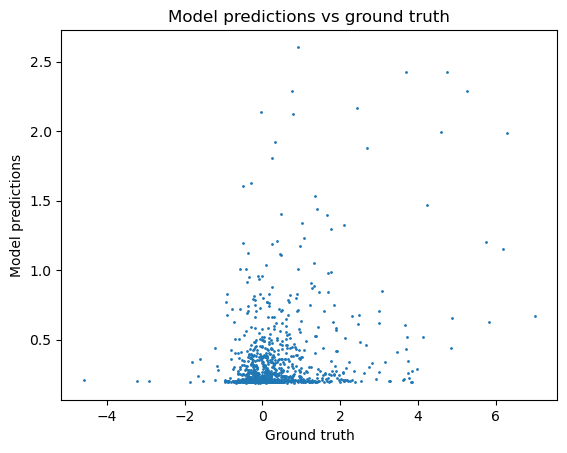

In [8]:
plt.scatter(gt,all_preds,s=1)
plt.xlabel("Ground truth")
plt.ylabel("Model predictions")
plt.title("Model predictions vs ground truth")
plt.show()

# Evaluate models on test sets
(ID and OOD both point to the same demo file; these should be changed to the actual files)

In [9]:
eval_model(species='human',
           arch='rnn',
           model_path='data/human/model/model_best.pth',
           out_file='data/human/model/results.txt')

In [10]:
%%bash
cat data/human/model/results.txt

ID	0.3076269708439276
OOD	0.3076269708439276
SNV	0.02664491270184708
